<a href="https://colab.research.google.com/github/Seghelicious/Spam-Classifier-with-NLTK/blob/main/Spam_Classifier_with_NLTK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this project is to build a Spam Classifier that  can detect a Spam mail from a Ham (In Mail). 

The task is divided into

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Download all the functions, corpora, tests to the local computer.

In [ ]:
import nltk
#nltk.download()
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_colwidth', 100)

Prints out all the functions, attributes and methods within the nltk package

In [ ]:
#dir(nltk)

In [ ]:
from nltk.corpus import stopwords
stopwords.words('english')[0:100:10]

['i',
 "you've",
 'himself',
 'they',
 'that',
 'been',
 'a',
 'while',
 'through',
 'in']

#### **Read in Text data**

In [ ]:
rawdata = pd.read_csv('/content/drive/MyDrive/LI - NLP Ex Files/Ex_Files_NLP_Python_ML_EssT/Exercise Files/Ch01/01_03/Start/SMSSpamCollection.tsv', sep = '\t', header = None)
rawdata.columns = ['label', 'body_text']

In [ ]:
rawdata[0:500] 

,label,body_text
0,ham,I've been searching for the right words to thank you for this breather. I promise i wont take yo...
1,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...
2,ham,"Nah I don't think he goes to usf, he lives around here though"
3,ham,Even my brother is not like to speak with me. They treat me like aids patent.
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!
...,...,...
495,ham,"Kate jackson rec center before 7ish, right?"
496,ham,Dear i have reache room
497,ham,"Fighting with the world is easy, u either win or lose bt fightng with some1 who is close to u is..."
498,ham,When can ü come out?


#### **Explore Dataset**

In [ ]:
print('Input data has {} rows and {} columns'.format(len(rawdata), len(rawdata.columns)))

Input data has 5568 rows and 2 columns


In [ ]:
print('Out of {} rows, {} are spam {} are ham'.format(len(rawdata), 
                                                      len(rawdata[rawdata['label'] == 'spam']), 
                                                      len(rawdata[rawdata['label'] == 'ham'])))

Out of 5568 rows, 746 are spam 4822 are ham


In [ ]:
print('Number of null in label: {}'.format(rawdata['label'].isnull().sum()))
print('Number of null in body_text: {}'.format(rawdata['body_text'].isnull().sum()))

Number of null in label: 0
Number of null in body_text: 0


#### **Preprocessing Text Data**

##### **Remove Punctuation**

In [ ]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Revove punctuation in body text

def remove_punctn(text):
  text_nopunctn = ''.join([word.lower() for word in text if word not in string.punctuation])
  return text_nopunctn


rawdata['body_text_clean'] = rawdata['body_text'].apply(lambda x: remove_punctn(x))
rawdata.head()

,label,body_text,body_text_clean
0,ham,I've been searching for the right words to thank you for this breather. I promise i wont take yo...,ive been searching for the right words to thank you for this breather i promise i wont take your...
1,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive e...
2,ham,"Nah I don't think he goes to usf, he lives around here though",nah i dont think he goes to usf he lives around here though
3,ham,Even my brother is not like to speak with me. They treat me like aids patent.,even my brother is not like to speak with me they treat me like aids patent
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,i have a date on sunday with will


##### **Tokenize**

In [ ]:
import re

# Split on non-word characters

def tokenize(text):
  tokens = re.split('\W+', text)
  return tokens

rawdata['body_text_tokenized'] = rawdata['body_text_clean'].apply(lambda x: tokenize(x.lower()))  
rawdata.head()

,label,body_text,body_text_clean,body_text_tokenized
0,ham,I've been searching for the right words to thank you for this breather. I promise i wont take yo...,ive been searching for the right words to thank you for this breather i promise i wont take your...,"[ive, been, searching, for, the, right, words, to, thank, you, for, this, breather, i, promise, ..."
1,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive e...,"[free, entry, in, 2, a, wkly, comp, to, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, to..."
2,ham,"Nah I don't think he goes to usf, he lives around here though",nah i dont think he goes to usf he lives around here though,"[nah, i, dont, think, he, goes, to, usf, he, lives, around, here, though]"
3,ham,Even my brother is not like to speak with me. They treat me like aids patent.,even my brother is not like to speak with me they treat me like aids patent,"[even, my, brother, is, not, like, to, speak, with, me, they, treat, me, like, aids, patent]"
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,i have a date on sunday with will,"[i, have, a, date, on, sunday, with, will]"


##### **Remove Stopwords**

In [ ]:
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(tokenized_list):
  text = [word for word in tokenized_list if word not in stopword]
  return text

rawdata['body_text_nostopwords'] = rawdata['body_text_tokenized'].apply(lambda x: remove_stopwords(x))
rawdata.head()

,label,body_text,body_text_clean,body_text_tokenized,body_text_nostopwords
0,ham,I've been searching for the right words to thank you for this breather. I promise i wont take yo...,ive been searching for the right words to thank you for this breather i promise i wont take your...,"[ive, been, searching, for, the, right, words, to, thank, you, for, this, breather, i, promise, ...","[ive, searching, right, words, thank, breather, promise, wont, take, help, granted, fulfil, prom..."
1,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive e...,"[free, entry, in, 2, a, wkly, comp, to, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, to...","[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, 87121, receiv..."
2,ham,"Nah I don't think he goes to usf, he lives around here though",nah i dont think he goes to usf he lives around here though,"[nah, i, dont, think, he, goes, to, usf, he, lives, around, here, though]","[nah, dont, think, goes, usf, lives, around, though]"
3,ham,Even my brother is not like to speak with me. They treat me like aids patent.,even my brother is not like to speak with me they treat me like aids patent,"[even, my, brother, is, not, like, to, speak, with, me, they, treat, me, like, aids, patent]","[even, brother, like, speak, treat, like, aids, patent]"
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,i have a date on sunday with will,"[i, have, a, date, on, sunday, with, will]","[date, sunday]"


##### **Stemming**

Stemming is the process of removing inflected words (or sometimes derived) to their word stem or root. 

In [ ]:
ps = nltk.PorterStemmer()
dir(ps)

['MARTIN_EXTENSIONS',
 'NLTK_EXTENSIONS',
 'ORIGINAL_ALGORITHM',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_abc_impl',
 '_apply_rule_list',
 '_contains_vowel',
 '_ends_cvc',
 '_ends_double_consonant',
 '_has_positive_measure',
 '_is_consonant',
 '_measure',
 '_replace_suffix',
 '_step1a',
 '_step1b',
 '_step1c',
 '_step2',
 '_step3',
 '_step4',
 '_step5a',
 '_step5b',
 'mode',
 'pool',
 'stem',
 'unicode_repr',
 'vowels']

In [ ]:
def stemming(tokenized_text):
  text = [ps.stem(word) for word in tokenized_text]
  return text

rawdata['body_text_stemmed'] = rawdata['body_text_nostopwords'].apply(lambda x: stemming(x))
rawdata.head(10)

,label,body_text,body_text_clean,body_text_tokenized,body_text_nostopwords,body_text_stemmed
0,ham,I've been searching for the right words to thank you for this breather. I promise i wont take yo...,ive been searching for the right words to thank you for this breather i promise i wont take your...,"[ive, been, searching, for, the, right, words, to, thank, you, for, this, breather, i, promise, ...","[ive, searching, right, words, thank, breather, promise, wont, take, help, granted, fulfil, prom...","[ive, search, right, word, thank, breather, promis, wont, take, help, grant, fulfil, promis, won..."
1,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive e...,"[free, entry, in, 2, a, wkly, comp, to, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, to...","[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, 87121, receiv...","[free, entri, 2, wkli, comp, win, fa, cup, final, tkt, 21st, may, 2005, text, fa, 87121, receiv,..."
2,ham,"Nah I don't think he goes to usf, he lives around here though",nah i dont think he goes to usf he lives around here though,"[nah, i, dont, think, he, goes, to, usf, he, lives, around, here, though]","[nah, dont, think, goes, usf, lives, around, though]","[nah, dont, think, goe, usf, live, around, though]"
3,ham,Even my brother is not like to speak with me. They treat me like aids patent.,even my brother is not like to speak with me they treat me like aids patent,"[even, my, brother, is, not, like, to, speak, with, me, they, treat, me, like, aids, patent]","[even, brother, like, speak, treat, like, aids, patent]","[even, brother, like, speak, treat, like, aid, patent]"
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,i have a date on sunday with will,"[i, have, a, date, on, sunday, with, will]","[date, sunday]","[date, sunday]"
5,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your call...,as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertu...,"[as, per, your, request, melle, melle, oru, minnaminunginte, nurungu, vettam, has, been, set, as...","[per, request, melle, melle, oru, minnaminunginte, nurungu, vettam, set, callertune, callers, pr...","[per, request, mell, mell, oru, minnaminungint, nurungu, vettam, set, callertun, caller, press, ..."
6,spam,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To c...,winner as a valued network customer you have been selected to receivea £900 prize reward to clai...,"[winner, as, a, valued, network, customer, you, have, been, selected, to, receivea, 900, prize, ...","[winner, valued, network, customer, selected, receivea, 900, prize, reward, claim, call, 0906170...","[winner, valu, network, custom, select, receivea, 900, prize, reward, claim, call, 09061701461, ..."
7,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with came...,had your mobile 11 months or more u r entitled to update to the latest colour mobiles with camer...,"[had, your, mobile, 11, months, or, more, u, r, entitled, to, update, to, the, latest, colour, m...","[mobile, 11, months, u, r, entitled, update, latest, colour, mobiles, camera, free, call, mobile...","[mobil, 11, month, u, r, entitl, updat, latest, colour, mobil, camera, free, call, mobil, updat,..."
8,ham,"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried ...",im gonna be home soon and i dont want to talk about this stuff anymore tonight k ive cried enoug...,"[im, gonna, be, home, soon, and, i, dont, want, to, talk, about, this, stuff, anymore, tonight, ...","[im, gonna, home, soon, dont, want, talk, stuff, anymore, tonight, k, ive, cried, enough, today]","[im, gonna, home, soon, dont, want, talk, stuff, anymor, tonight, k, ive, cri, enough, today]"


##### **Lemmatization**

Lemmatization is the process of groupng together inflected forms of a word so that they can be analysed as a single term, identified as the word's lemma. It is the process of using the vocabulary analysis of a word aiming to remove inflectional endings to return the dictionary form of a word.

Lemmatization is similar to stemming in that the goal of both processes is to  condense derived forms of a word into the base forms. 

Stemming is typically faster as it simply chops off the end of a word using heuristics without any understanding of the context in which a word is used. Lemmatization, however, is typically more accurate as it uses more informed analysis to create groups of words with similar meanings based on the context around which the word is used.

Lemmatization always returns a dictionary word because of the different contexts considered, the downside is that it may be computationally more expensive.

In [ ]:
wn = nltk.WordNetLemmatizer()
#dir(wn)

def lemmatized(tokenized_text):
  text = [wn.lemmatize(word) for word in tokenized_text]
  return text

rawdata['body_text_lemmatized'] = rawdata['body_text_nostopwords'].apply(lambda x: lemmatized(x))
rawdata.head()

,label,body_text,body_text_clean,body_text_tokenized,body_text_nostopwords,body_text_stemmed,body_text_lemmatized
0,ham,I've been searching for the right words to thank you for this breather. I promise i wont take yo...,ive been searching for the right words to thank you for this breather i promise i wont take your...,"[ive, been, searching, for, the, right, words, to, thank, you, for, this, breather, i, promise, ...","[ive, searching, right, words, thank, breather, promise, wont, take, help, granted, fulfil, prom...","[ive, search, right, word, thank, breather, promis, wont, take, help, grant, fulfil, promis, won...","[ive, searching, right, word, thank, breather, promise, wont, take, help, granted, fulfil, promi..."
1,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive e...,"[free, entry, in, 2, a, wkly, comp, to, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, to...","[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, 87121, receiv...","[free, entri, 2, wkli, comp, win, fa, cup, final, tkt, 21st, may, 2005, text, fa, 87121, receiv,...","[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, 87121, receiv..."
2,ham,"Nah I don't think he goes to usf, he lives around here though",nah i dont think he goes to usf he lives around here though,"[nah, i, dont, think, he, goes, to, usf, he, lives, around, here, though]","[nah, dont, think, goes, usf, lives, around, though]","[nah, dont, think, goe, usf, live, around, though]","[nah, dont, think, go, usf, life, around, though]"
3,ham,Even my brother is not like to speak with me. They treat me like aids patent.,even my brother is not like to speak with me they treat me like aids patent,"[even, my, brother, is, not, like, to, speak, with, me, they, treat, me, like, aids, patent]","[even, brother, like, speak, treat, like, aids, patent]","[even, brother, like, speak, treat, like, aid, patent]","[even, brother, like, speak, treat, like, aid, patent]"
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,i have a date on sunday with will,"[i, have, a, date, on, sunday, with, will]","[date, sunday]","[date, sunday]","[date, sunday]"


In [ ]:
def lemmatized(tokenized_text):
  text = ' '.join([wn.lemmatize(word) for word in tokenized_text])
  return text

rawdata['body_text_lemmatized_cleaned'] = rawdata['body_text_nostopwords'].apply(lambda x: lemmatized(x))
rawdata.head()

,label,body_text,body_text_clean,body_text_tokenized,body_text_nostopwords,body_text_stemmed,body_text_lemmatized,body_text_lemmatized_cleaned
0,ham,I've been searching for the right words to thank you for this breather. I promise i wont take yo...,ive been searching for the right words to thank you for this breather i promise i wont take your...,"[ive, been, searching, for, the, right, words, to, thank, you, for, this, breather, i, promise, ...","[ive, searching, right, words, thank, breather, promise, wont, take, help, granted, fulfil, prom...","[ive, search, right, word, thank, breather, promis, wont, take, help, grant, fulfil, promis, won...","[ive, searching, right, word, thank, breather, promise, wont, take, help, granted, fulfil, promi...",ive searching right word thank breather promise wont take help granted fulfil promise wonderful ...
1,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive e...,"[free, entry, in, 2, a, wkly, comp, to, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, to...","[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, 87121, receiv...","[free, entri, 2, wkli, comp, win, fa, cup, final, tkt, 21st, may, 2005, text, fa, 87121, receiv,...","[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, 87121, receiv...",free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questions...
2,ham,"Nah I don't think he goes to usf, he lives around here though",nah i dont think he goes to usf he lives around here though,"[nah, i, dont, think, he, goes, to, usf, he, lives, around, here, though]","[nah, dont, think, goes, usf, lives, around, though]","[nah, dont, think, goe, usf, live, around, though]","[nah, dont, think, go, usf, life, around, though]",nah dont think go usf life around though
3,ham,Even my brother is not like to speak with me. They treat me like aids patent.,even my brother is not like to speak with me they treat me like aids patent,"[even, my, brother, is, not, like, to, speak, with, me, they, treat, me, like, aids, patent]","[even, brother, like, speak, treat, like, aids, patent]","[even, brother, like, speak, treat, like, aid, patent]","[even, brother, like, speak, treat, like, aid, patent]",even brother like speak treat like aid patent
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,i have a date on sunday with will,"[i, have, a, date, on, sunday, with, will]","[date, sunday]","[date, sunday]","[date, sunday]",date sunday


##### **Vectorization**

Vectorization is the process of encoding text as integers to create feature vectors. A feature vector is an n-dimensional vector of numerical features that represent an object.

###### **Count Vectiorization**

Count Vectorizer creates a document-term matrix where the entry of each cell will be a count of the number of times that a word occurs in that document.



In [ ]:
count_vect = CountVectorizer(analyzer=stemming)
x_counts = count_vect.fit_transform(rawdata['body_text_lemmatized'])
print(x_counts.shape)
print(count_vect.get_feature_names())

(5568, 8088)
['', '0', '008704050406', '0089mi', '0121', '01223585236', '01223585334', '0125698789', '02', '020603', '0207', '02070836089', '02072069400', '02073162414', '02085076972', '020903', '021', '050703', '0578', '06', '060505', '061104', '07008009200', '07046744435', '07090201529', '07090298926', '07099833605', '071104', '07123456789', '0721072', '07732584351', '07734396839', '07742676969', '07753741225', '0776xxxxxxx', '07786200117', '077xxx', '078', '07801543489', '07808', '07808247860', '07808726822', '07815296484', '07821230901', '0784987', '0789xxxxxxx', '0794674629107880867867', '0796xxxxxx', '07973788240', '07xxxxxxxxx', '0800', '08000407165', '08000776320', '08000839402', '08000930705', '08000938767', '08001950382', '08002888812', '08002986030', '08002986906', '08002988890', '08006344447', '0808', '08081263000', '08081560665', '0825', '0844', '08448350055', '08448714184', '0845', '08450542832', '08452810071', '08452810073', '08452810075over18', '0870', '08700621170150p'

###### **Applying CountVectorizer to a smaller sample**

In [ ]:
rawdata_sample = rawdata[0:20]

count_vect_sample = CountVectorizer(analyzer=stemming)
x_counts_sample = count_vect_sample.fit_transform(rawdata_sample['body_text_lemmatized'])
print(x_counts_sample.shape)
print(count_vect_sample.get_feature_names())

(20, 200)
['08002986030', '08452810075over18', '09061701461', '1', '100', '100000', '11', '12', '150pday', '16', '2', '20000', '2005', '21st', '3', '4', '4403ldnw1a7rw18', '4txtú120', '6day', '81010', '87077', '87121', '87575', '9', '900', 'aft', 'aid', 'alreadi', 'anymor', 'appli', 'ard', 'around', 'b', 'bless', 'breather', 'brother', 'call', 'caller', 'callertun', 'camera', 'cash', 'chanc', 'claim', 'click', 'co', 'code', 'colour', 'comin', 'comp', 'copi', 'cost', 'credit', 'cri', 'csh11', 'cup', 'custom', 'da', 'date', 'dont', 'eg', 'eh', 'england', 'enough', 'entitl', 'entri', 'even', 'fa', 'feel', 'final', 'fine', 'finish', 'first', 'free', 'friend', 'fulfil', 'go', 'goalsteam', 'gonna', 'gota', 'grant', 'ha', 'help', 'hl', 'home', 'hour', 'httpwap', 'im', 'info', 'ive', 'jackpot', 'joke', 'k', 'kim', 'kl341', 'lar', 'latest', 'lccltd', 'life', 'like', 'link', 'lor', 'lunch', 'macedonia', 'make', 'may', 'mell', 'membership', 'messag', 'minnaminungint', 'miss', 'mobil', 'month', 'n

##### **Vectorizers without Sparse Matrices**

###### A **Sparse Matrix** is a matrix in which most entries are zero. In the interest of efficient storage, a sparse matrix will be stored only by storing the locations of the non-zero elements.

In [ ]:
x_counts_sample

<20x200 sparse matrix of type '<class 'numpy.int64'>'
	with 228 stored elements in Compressed Sparse Row format>

In [ ]:
x_counts_df = pd.DataFrame(x_counts_sample.toarray())
x_counts_df.columns = count_vect_sample.get_feature_names()
x_counts_df.head()

,08002986030,08452810075over18,09061701461,1,100,100000,11,12,150pday,16,2,20000,2005,21st,3,4,4403ldnw1a7rw18,4txtú120,6day,81010,87077,87121,87575,9,900,aft,aid,alreadi,anymor,appli,ard,around,b,bless,breather,brother,call,caller,callertun,camera,...,text,thank,think,though,time,tkt,today,tonight,treat,tri,trywal,tsandc,txt,u,updat,ur,urgent,use,usf,v,valid,valu,vettam,want,wap,watch,way,week,wet,win,winner,wkli,wonder,wont,word,wwwdbuknet,xxxmobilemovieclub,xxxmobilemovieclubcomnqjkgighjjgcbl,ye,ü
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### **N-gram Vectorizer**

The **N-gram Vectorizer** creates a document-term matrix where counts still occupy the cell but instead of columns repreesenbbting single terms, they represent all combinations of adjacent words of length in your text.

- A **bigram** (n = 2) is a matrix with word combinations of two adjacent words in a string.
- A **trigram** (n = 3) is a matrix with word combinations of three adjacent words in a string.
- A **fourgram** (n = 4) is a matrix with word combinations of four adjacent words in a string.

In [ ]:
ngram_vect = CountVectorizer(ngram_range = (2, 2))
x_counts_ngram = ngram_vect.fit_transform(rawdata['body_text_lemmatized_cleaned'])
print(ngram_vect.get_feature_names())
print(x_counts_ngram.shape)

['008704050406 sp', '0089my last', '0121 2025050', '01223585236 xx', '01223585334 cum', '0125698789 ring', '02 user', '020603 2nd', '0207 153', '02072069400 bx', '02073162414 cost', '02085076972 reply', '020903 2nd', '021 3680', '021 3680offer', '050703 tcsbcm4235wc1n3xx', '06 good', '07046744435 arrange', '07090298926 reschedule', '07099833605 reschedule', '07123456789 87077', '0721072 find', '07732584351 rodger', '07734396839 ibh', '07742676969 show', '07753741225 show', '0776xxxxxxx uve', '077xxx 2000', '07801543489 guaranteed', '07808 xxxxxx', '07808247860 show', '07808726822 awarded', '07815296484 show', '0784987 show', '0789xxxxxxx today', '0796xxxxxx today', '07973788240 show', '07xxxxxxxxx 2000', '07xxxxxxxxx show', '0800 0721072', '0800 169', '0800 18', '0800 195', '0800 1956669', '0800 505060', '0800 542', '08000407165 18', '08000776320 reply', '08000839402 2stoptx', '08000839402 2stoptxt', '08000839402 call', '08000839402 call2optout4qf2', '08000839402 call2optoutf4q', '0800

###### **Apply N-gram Vecvtorizer to smaller sample**

In [ ]:
ngram_vect_sample = CountVectorizer(ngram_range = (2, 2))
x_counts_ngram_sample = ngram_vect_sample.fit_transform(rawdata_sample['body_text_lemmatized_cleaned'])
print(ngram_vect_sample.get_feature_names())
print(x_counts_ngram_sample.shape)

['09061701461 claim', '100 20000', '100000 prize', '11 month', '12 hour', '150pday 6days', '16 tsandcs', '20000 pound', '2005 text', '21st may', '4txtú120 poboxox36504w45wq', '6days 16', '81010 tc', '87077 eg', '87077 trywales', '87121 receive', '87575 cost', '900 prize', 'aft finish', 'aid patent', 'anymore tonight', 'apply 08452810075over18s', 'apply reply', 'ard smth', 'around though', 'blessing time', 'breather promise', 'brother like', 'call 09061701461', 'call mobile', 'caller press', 'callertune caller', 'camera free', 'cash 100', 'chance win', 'claim 81010', 'claim call', 'claim code', 'click httpwap', 'click wap', 'co free', 'code kl341', 'colour mobile', 'comp win', 'copy friend', 'cost 150pday', 'credit click', 'cried enough', 'csh11 send', 'cup final', 'customer selected', 'da stock', 'date sunday', 'dont miss', 'dont think', 'dont want', 'eg england', 'eh remember', 'england 87077', 'england macedonia', 'enough today', 'entitled update', 'entry questionstd', 'entry wkly', 

In [ ]:
x_counts_ngram_df = pd.DataFrame(x_counts_ngram_sample.toarray())
x_counts_ngram_df.columns = ngram_vect_sample.get_feature_names()
x_counts_ngram_df.head()

,09061701461 claim,100 20000,100000 prize,11 month,12 hour,150pday 6days,16 tsandcs,20000 pound,2005 text,21st may,4txtú120 poboxox36504w45wq,6days 16,81010 tc,87077 eg,87077 trywales,87121 receive,87575 cost,900 prize,aft finish,aid patent,anymore tonight,apply 08452810075over18s,apply reply,ard smth,around though,blessing time,breather promise,brother like,call 09061701461,call mobile,caller press,callertune caller,camera free,cash 100,chance win,claim 81010,claim call,claim code,click httpwap,click wap,...,text fa,thank breather,think go,tkts 21st,tonight ive,treat like,try month,trywales scotland,tsandcs apply,txt csh11,txt message,txt ratetcs,txt ur,txt word,update co,update latest,ur lunch,ur national,urgent week,use credit,usf life,valid 12,valued network,vettam set,want talk,wap link,way feel,way gota,week free,win cash,win fa,winner valued,wkly comp,wonderful blessing,wont take,word claim,word thank,wwwdbuknet lccltd,xxxmobilemovieclub use,yes naughty
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0
1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### **Inverse Document Frequency Weighting**

###### **Term Frequency - Inverse Document Frequency**

###### **TF-IDF Equation**

Wi, j = tfi, j * log (N/dfi)

where,
- tfi, j = number of times i occurs in j divided by total number of terms in j
- dfi = number of documents containing i
- N = total number of documents

**TF-IDF** creates a document-term matrix where there is still one row per text message and the columns still represent single or unique terms. But instead of the cells representing a count, they represent a weighting which identifies how important a word in an individual text message. Sammarily, the TF-IDF method helps you pull out important but seldom used words.



In [ ]:
tfidf_vect = TfidfVectorizer(analyzer = stemming)
x_tfidf = tfidf_vect.fit_transform(rawdata['body_text_lemmatized'])
print(tfidf_vect.get_feature_names())
print(x_tfidf.shape)

['', '0', '008704050406', '0089mi', '0121', '01223585236', '01223585334', '0125698789', '02', '020603', '0207', '02070836089', '02072069400', '02073162414', '02085076972', '020903', '021', '050703', '0578', '06', '060505', '061104', '07008009200', '07046744435', '07090201529', '07090298926', '07099833605', '071104', '07123456789', '0721072', '07732584351', '07734396839', '07742676969', '07753741225', '0776xxxxxxx', '07786200117', '077xxx', '078', '07801543489', '07808', '07808247860', '07808726822', '07815296484', '07821230901', '0784987', '0789xxxxxxx', '0794674629107880867867', '0796xxxxxx', '07973788240', '07xxxxxxxxx', '0800', '08000407165', '08000776320', '08000839402', '08000930705', '08000938767', '08001950382', '08002888812', '08002986030', '08002986906', '08002988890', '08006344447', '0808', '08081263000', '08081560665', '0825', '0844', '08448350055', '08448714184', '0845', '08450542832', '08452810071', '08452810073', '08452810075over18', '0870', '08700621170150p', '0870121318

###### **Apply TF-IDF to smaller sample**

In [ ]:
tfidf_vect_sample = TfidfVectorizer(analyzer = stemming)
x_tfidf_sample = tfidf_vect_sample.fit_transform(rawdata_sample['body_text_lemmatized'])
print(tfidf_vect_sample.get_feature_names())
print(x_tfidf_sample.shape)

['08002986030', '08452810075over18', '09061701461', '1', '100', '100000', '11', '12', '150pday', '16', '2', '20000', '2005', '21st', '3', '4', '4403ldnw1a7rw18', '4txtú120', '6day', '81010', '87077', '87121', '87575', '9', '900', 'aft', 'aid', 'alreadi', 'anymor', 'appli', 'ard', 'around', 'b', 'bless', 'breather', 'brother', 'call', 'caller', 'callertun', 'camera', 'cash', 'chanc', 'claim', 'click', 'co', 'code', 'colour', 'comin', 'comp', 'copi', 'cost', 'credit', 'cri', 'csh11', 'cup', 'custom', 'da', 'date', 'dont', 'eg', 'eh', 'england', 'enough', 'entitl', 'entri', 'even', 'fa', 'feel', 'final', 'fine', 'finish', 'first', 'free', 'friend', 'fulfil', 'go', 'goalsteam', 'gonna', 'gota', 'grant', 'ha', 'help', 'hl', 'home', 'hour', 'httpwap', 'im', 'info', 'ive', 'jackpot', 'joke', 'k', 'kim', 'kl341', 'lar', 'latest', 'lccltd', 'life', 'like', 'link', 'lor', 'lunch', 'macedonia', 'make', 'may', 'mell', 'membership', 'messag', 'minnaminungint', 'miss', 'mobil', 'month', 'nah', 'name

In [ ]:
x_tfidf_df = pd.DataFrame(x_tfidf_sample.toarray())
x_tfidf_df.columns = tfidf_vect_sample.get_feature_names()
x_tfidf_df.head()

,08002986030,08452810075over18,09061701461,1,100,100000,11,12,150pday,16,2,20000,2005,21st,3,4,4403ldnw1a7rw18,4txtú120,6day,81010,87077,87121,87575,9,900,aft,aid,alreadi,anymor,appli,ard,around,b,bless,breather,brother,call,caller,callertun,camera,...,text,thank,think,though,time,tkt,today,tonight,treat,tri,trywal,tsandc,txt,u,updat,ur,urgent,use,usf,v,valid,valu,vettam,want,wap,watch,way,week,wet,win,winner,wkli,wonder,wont,word,wwwdbuknet,xxxmobilemovieclub,xxxmobilemovieclubcomnqjkgighjjgcbl,ye,ü
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.238737,0.238737,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.238737,0.000000,0.000000,0.238737,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.238737,0.238737,0.209853,0.0,0.0,0.0,0.0,0.0
1,0.0,0.198986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157831,0.0,0.198986,0.198986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.198986,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.174912,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.198986,0.000000,0.000000,0.000000,0.000000,0.198986,0.0,0.0,0.000000,0.0,0.0,0.0,0.133757,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174912,0.0,0.198986,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.371179,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.371179,0.371179,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.371179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.316228,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.316228,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.316228,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


Summarily, TF-IDF is basically a count vectorizer that  includes some   consideration for the length of the document and also how common the word is across other text messages. 

N-grams are used within either of these two methods to look for groups of adjacent words instead of just looking for single terms.

### **Feature Engineering**

###### **Hypothesis**

1. Spam messages tend to be longer than ham messages.
2. Spam messages tend to contain more punctuations than ham messages.

Based on these hypothesis, I shall create two new features. These are: 
- body_text_length: which is the length of the text message.
- %punctn: which is the percentage of the message that are punctation marks.

###### **Create feature text message length**

In [ ]:
rawdata['body_text_length'] = rawdata['body_text'].apply(lambda x: len(x) - x.count(' '))
rawdata.head()

,label,body_text,body_text_clean,body_text_tokenized,body_text_nostopwords,body_text_stemmed,body_text_lemmatized,body_text_lemmatized_cleaned,body_text_length
0,ham,I've been searching for the right words to thank you for this breather. I promise i wont take yo...,ive been searching for the right words to thank you for this breather i promise i wont take your...,"[ive, been, searching, for, the, right, words, to, thank, you, for, this, breather, i, promise, ...","[ive, searching, right, words, thank, breather, promise, wont, take, help, granted, fulfil, prom...","[ive, search, right, word, thank, breather, promis, wont, take, help, grant, fulfil, promis, won...","[ive, searching, right, word, thank, breather, promise, wont, take, help, granted, fulfil, promi...",ive searching right word thank breather promise wont take help granted fulfil promise wonderful ...,160
1,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive e...,"[free, entry, in, 2, a, wkly, comp, to, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, to...","[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, 87121, receiv...","[free, entri, 2, wkli, comp, win, fa, cup, final, tkt, 21st, may, 2005, text, fa, 87121, receiv,...","[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, 87121, receiv...",free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questions...,128
2,ham,"Nah I don't think he goes to usf, he lives around here though",nah i dont think he goes to usf he lives around here though,"[nah, i, dont, think, he, goes, to, usf, he, lives, around, here, though]","[nah, dont, think, goes, usf, lives, around, though]","[nah, dont, think, goe, usf, live, around, though]","[nah, dont, think, go, usf, life, around, though]",nah dont think go usf life around though,49
3,ham,Even my brother is not like to speak with me. They treat me like aids patent.,even my brother is not like to speak with me they treat me like aids patent,"[even, my, brother, is, not, like, to, speak, with, me, they, treat, me, like, aids, patent]","[even, brother, like, speak, treat, like, aids, patent]","[even, brother, like, speak, treat, like, aid, patent]","[even, brother, like, speak, treat, like, aid, patent]",even brother like speak treat like aid patent,62
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,i have a date on sunday with will,"[i, have, a, date, on, sunday, with, will]","[date, sunday]","[date, sunday]","[date, sunday]",date sunday,28


###### **Create feature for percentage of text that is punctuation**

In [ ]:
def count_punctn(text):
  count = sum([1 for char in text if char in string.punctuation])
  return round((count/(len(text) - text.count(' ')) * 100), 2)

rawdata['%punctn'] = rawdata['body_text'].apply(lambda x: count_punctn(x))
rawdata.head()

,label,body_text,body_text_clean,body_text_tokenized,body_text_nostopwords,body_text_stemmed,body_text_lemmatized,body_text_lemmatized_cleaned,body_text_length,%punctn
0,ham,I've been searching for the right words to thank you for this breather. I promise i wont take yo...,ive been searching for the right words to thank you for this breather i promise i wont take your...,"[ive, been, searching, for, the, right, words, to, thank, you, for, this, breather, i, promise, ...","[ive, searching, right, words, thank, breather, promise, wont, take, help, granted, fulfil, prom...","[ive, search, right, word, thank, breather, promis, wont, take, help, grant, fulfil, promis, won...","[ive, searching, right, word, thank, breather, promise, wont, take, help, granted, fulfil, promi...",ive searching right word thank breather promise wont take help granted fulfil promise wonderful ...,160,2.50
1,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive e...,"[free, entry, in, 2, a, wkly, comp, to, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, to...","[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, 87121, receiv...","[free, entri, 2, wkli, comp, win, fa, cup, final, tkt, 21st, may, 2005, text, fa, 87121, receiv,...","[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, 87121, receiv...",free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questions...,128,4.69
2,ham,"Nah I don't think he goes to usf, he lives around here though",nah i dont think he goes to usf he lives around here though,"[nah, i, dont, think, he, goes, to, usf, he, lives, around, here, though]","[nah, dont, think, goes, usf, lives, around, though]","[nah, dont, think, goe, usf, live, around, though]","[nah, dont, think, go, usf, life, around, though]",nah dont think go usf life around though,49,4.08
3,ham,Even my brother is not like to speak with me. They treat me like aids patent.,even my brother is not like to speak with me they treat me like aids patent,"[even, my, brother, is, not, like, to, speak, with, me, they, treat, me, like, aids, patent]","[even, brother, like, speak, treat, like, aids, patent]","[even, brother, like, speak, treat, like, aid, patent]","[even, brother, like, speak, treat, like, aid, patent]",even brother like speak treat like aid patent,62,3.23
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,i have a date on sunday with will,"[i, have, a, date, on, sunday, with, will]","[date, sunday]","[date, sunday]","[date, sunday]",date sunday,28,7.14


##### **Evaluate created features**

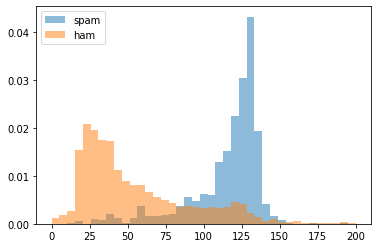

In [ ]:
bins = np.linspace(0, 200, 40)

pyplot.hist(rawdata[rawdata['label'] == 'spam']['body_text_length'], bins, alpha = 0.5, density = True, label = 'spam')
pyplot.hist(rawdata[rawdata['label'] == 'ham']['body_text_length'], bins, alpha = 0.5, density = True, label = 'ham')
pyplot.legend(loc = 'upper left')
pyplot.show()

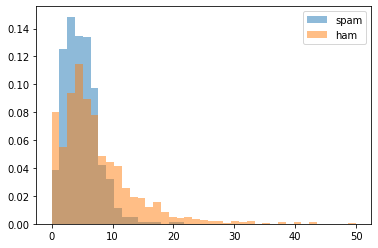

In [ ]:
bins = np.linspace(0, 50, 40)

pyplot.hist(rawdata[rawdata['label'] == 'spam']['%punctn'], bins, alpha = 0.5, density = True, label = 'spam')
pyplot.hist(rawdata[rawdata['label'] == 'ham']['%punctn'], bins, alpha = 0.5, density = True, label = 'ham')
pyplot.legend(loc = 'upper right')
pyplot.show()

From  the two plots, it is clear that the body text length is a better feature than %punctuation as there is a huge variability in the body text length of spam and ham messages.

%punctuation on the other hand does not offer any  variability between ham and spam nessages.

The earlier hypothesis which stated that spam messages tend to be longer than ham messages, seems to be correct based on this evaluation. However, the hypothesis that spam messages tend to contain more punctuation marks than ham messages does not appear to be accurate. But since there is some separation between the distributions, the feature will be used for the model just to see how much value the model may be able to extract from it.

##### **Feature Transformation**

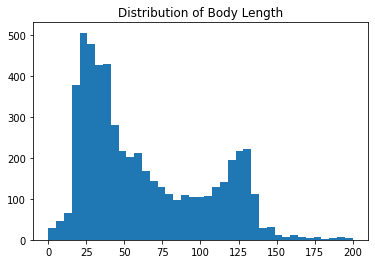

In [ ]:
bins = np.linspace(0, 200, 40)

pyplot.hist(rawdata['body_text_length'], bins)
pyplot.title('Distribution of Body Length')
pyplot.show()

The distribution of body length is bimodal with two different peaks. The data is not skewed, neither does it have outliers.

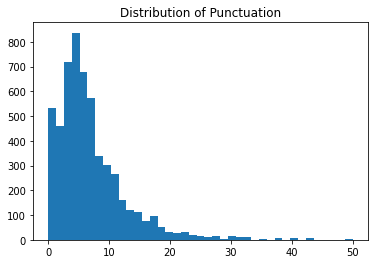

In [ ]:
bins = np.linspace(0, 50, 40)

pyplot.hist(rawdata['%punctn'], bins)
pyplot.title('Distribution of Punctuation')
pyplot.show()

The distribution of punctuation is right skewed with a lot of outliers. 

So the feature to transform based on these two plots is the %punctn. To do this the Box-Cox transformation shall be used to, 
- determine the range of exponents to test.
- apply each transformation to each value of the %punctn.
- use some criteria to determine which transformation yields the best distribution.


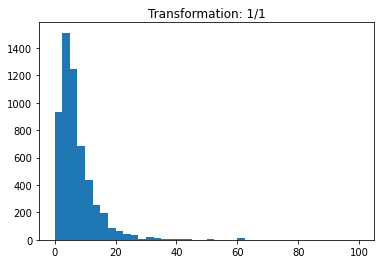

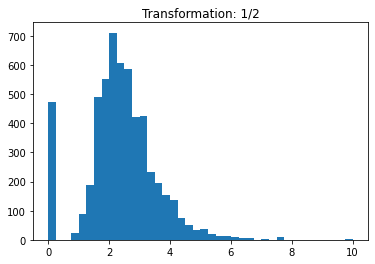

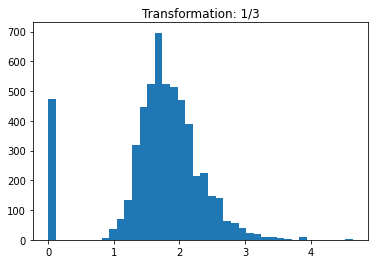

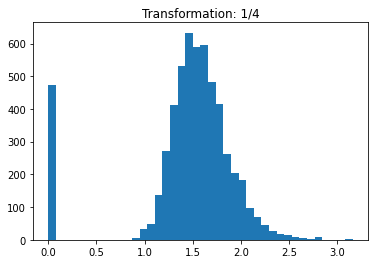

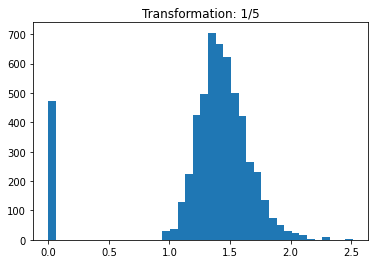

In [ ]:
for i in [1, 2, 3, 4, 5]:
  pyplot.hist((rawdata['%punctn']) ** (1/i), bins = 40)
  pyplot.title('Transformation: 1/{}'.format(str(i)))
  pyplot.show()

### **Model Development**

In [ ]:
# TF-IDF
x_features_tfidf = pd.concat([rawdata['body_text_length'], rawdata['%punctn'], pd.DataFrame(x_tfidf.toarray())], axis = 1)
x_features_tfidf.head()

,body_text_length,%punctn,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,8048,8049,8050,8051,8052,8053,8054,8055,8056,8057,8058,8059,8060,8061,8062,8063,8064,8065,8066,8067,8068,8069,8070,8071,8072,8073,8074,8075,8076,8077,8078,8079,8080,8081,8082,8083,8084,8085,8086,8087
0,160,2.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,128,4.69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,49,4.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,62,3.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28,7.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Count Vectorizer
x_features_count = pd.concat([rawdata['body_text_length'], rawdata['%punctn'], pd.DataFrame(x_counts.toarray())], axis = 1)
x_features_count.head()

,body_text_length,%punctn,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,8048,8049,8050,8051,8052,8053,8054,8055,8056,8057,8058,8059,8060,8061,8062,8063,8064,8065,8066,8067,8068,8069,8070,8071,8072,8073,8074,8075,8076,8077,8078,8079,8080,8081,8082,8083,8084,8085,8086,8087
0,160,2.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,128,4.69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,49,4.08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,62,3.23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,28,7.14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


###### **Explore Random Forests Classifier Attributes and Hyperparameters**

In [ ]:
print(dir(RandomForestClassifier))
print(RandomForestClassifier())

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_estimator_type', '_get_param_names', '_get_tags', '_make_estimator', '_more_tags', '_required_parameters', '_set_oob_score', '_validate_X_predict', '_validate_estimator', '_validate_y_class_weight', 'apply', 'decision_path', 'feature_importances_', 'fit', 'get_params', 'predict', 'predict_log_proba', 'predict_proba', 'score', 'set_params']
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_sample

In [ ]:
rf = RandomForestClassifier(n_jobs = -1)
kfold = KFold(n_splits = 5)
cross_val_score(rf, x_features_tfidf, rawdata['label'], cv = kfold, scoring = 'roc_auc', n_jobs = -1)

array([0.98702173, 0.99650492, 0.9759281 , 0.98347869, 0.99170704])

###### **Random Forest with Holdout test set**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_features_tfidf, rawdata['label'], test_size = 0.2)

In [ ]:
rf = RandomForestClassifier(n_estimators = 50, max_depth = 20, n_jobs = -1)
rf_model = rf.fit(x_train, y_train)

In [ ]:
sorted(zip(rf_model.feature_importances_, x_train.columns), reverse = True)[0:10]

[(0.0824880880916007, 'body_text_length'),
 (0.040690360832598124, 1800),
 (0.03350721125718332, 4790),
 (0.03044775981381519, 2027),
 (0.027774576253344053, 7337),
 (0.022593221606949657, 3129),
 (0.017050844856267858, 688),
 (0.015512488246350122, 6273),
 (0.01473744650624071, 6733),
 (0.014707188900173997, 1878)]

In [ ]:
y_pred = rf_model.predict(x_test)

In [ ]:
precision, recall, fscore, support = score(y_test, y_pred, pos_label = 'spam', average = 'binary')

In [ ]:
print('Precision: {}/ Recall: {}/ Accuracy: {}'. format(round(precision, 3), 
                                                        round(recall, 3), 
                                                        round((y_pred == y_test).sum() / len(y_pred), 3)))

Precision: 1.0/ Recall: 0.539/ Accuracy: 0.942


This means that,
- All mail in the spam folder is actually spam (100% Precision)
- 61% of all spam received in your email was placed in your spam folder correctly (61% Recall), which means that the other 39% of spam (wrongly classified) went into your inbox.
- Of all the email received - spam and non-spam, they were accurately placed in either spam or inbox folders 95% of the time (95% Accuracy)


##### **Random Forest with Grid Search**

In [ ]:
def train_RF(n_est, depth):
  rf = RandomForestClassifier(n_estimators = n_est, max_depth = depth, n_jobs = -1)
  rf_model = rf.fit(x_train, y_train)
  y_pred_rf = rf_model.predict(x_test)
  precision, recall, fscore, support = score(y_test, y_pred, pos_label = 'spam', average = 'binary')
  print('Estimators: {} / Depth: {} ------ Precision: {} / Recall: {} ? Accuracy: {}'.format(
      n_est, depth, round(precision, 3), round(recall, 3), round(fscore, 3), 
                                                        round((y_pred == y_test).sum() / len(y_pred), 3)))


In [ ]:
for n_est in [10, 50, 100, 200]:
  for depth in [10, 20, 30, None]:
    train_RF(n_est, depth)

Estimators: 10 / Depth: 10 ------ Precision: 1.0 / Recall: 0.539 ? Accuracy: 0.7
Estimators: 10 / Depth: 20 ------ Precision: 1.0 / Recall: 0.539 ? Accuracy: 0.7
Estimators: 10 / Depth: 30 ------ Precision: 1.0 / Recall: 0.539 ? Accuracy: 0.7
Estimators: 10 / Depth: None ------ Precision: 1.0 / Recall: 0.539 ? Accuracy: 0.7
Estimators: 50 / Depth: 10 ------ Precision: 1.0 / Recall: 0.539 ? Accuracy: 0.7
Estimators: 50 / Depth: 20 ------ Precision: 1.0 / Recall: 0.539 ? Accuracy: 0.7
Estimators: 50 / Depth: 30 ------ Precision: 1.0 / Recall: 0.539 ? Accuracy: 0.7
Estimators: 50 / Depth: None ------ Precision: 1.0 / Recall: 0.539 ? Accuracy: 0.7
Estimators: 100 / Depth: 10 ------ Precision: 1.0 / Recall: 0.539 ? Accuracy: 0.7
Estimators: 100 / Depth: 20 ------ Precision: 1.0 / Recall: 0.539 ? Accuracy: 0.7
Estimators: 100 / Depth: 30 ------ Precision: 1.0 / Recall: 0.539 ? Accuracy: 0.7
Estimators: 100 / Depth: None ------ Precision: 1.0 / Recall: 0.539 ? Accuracy: 0.7
Estimators: 200 / 

In [ ]:
rf = RandomForestClassifier()
params = {'n_estimators': [10, 150, 300],
         'max_depth': [30, 60, 90, None]}
gs = GridSearchCV(rf, params, cv = 5, n_jobs = -1)
gs_fit = gs.fit(x_features_tfidf, rawdata['label'])
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending = False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,1.227261,0.007238,0.065572,0.005426,60,10,"{'max_depth': 60, 'n_estimators': 10}",0.976661,0.973968,0.973968,0.970350,0.974843,0.973958,0.002054,1
8,36.557764,0.666279,0.380492,0.040858,90,300,"{'max_depth': 90, 'n_estimators': 300}",0.979354,0.976661,0.974865,0.969452,0.969452,0.973957,0.003946,2
11,37.029783,5.244971,0.384923,0.048214,None,300,"{'max_depth': None, 'n_estimators': 300}",0.976661,0.978456,0.973070,0.967655,0.970350,0.973238,0.003962,3
10,21.022196,0.804334,0.259398,0.035781,None,150,"{'max_depth': None, 'n_estimators': 150}",0.976661,0.976661,0.975763,0.967655,0.969452,0.973238,0.003881,4
7,18.289931,0.124881,0.199948,0.003852,90,150,"{'max_depth': 90, 'n_estimators': 150}",0.976661,0.973070,0.973968,0.966757,0.969452,0.971981,0.003485,5


In [ ]:
rf = RandomForestClassifier()
params = {'n_estimators': [10, 150, 300],
         'max_depth': [30, 60, 90, None]}
gs = GridSearchCV(rf, params, cv = 5, n_jobs = -1)
gs_fit = gs.fit(x_features_count, rawdata['label'])
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending = False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,21.142372,0.737001,0.243200,0.006422,None,150,"{'max_depth': None, 'n_estimators': 150}",0.977558,0.973968,0.973968,0.967655,0.971249,0.972880,0.003293,1
8,37.132281,1.085185,0.371624,0.010314,90,300,"{'max_depth': 90, 'n_estimators': 300}",0.978456,0.972172,0.973968,0.968553,0.969452,0.972520,0.003538,2
7,19.116335,0.602647,0.215932,0.004545,90,150,"{'max_depth': 90, 'n_estimators': 150}",0.980251,0.974865,0.973968,0.967655,0.965858,0.972519,0.005204,3
6,1.755438,0.045030,0.068965,0.001533,90,10,"{'max_depth': 90, 'n_estimators': 10}",0.979354,0.980251,0.969479,0.960467,0.972147,0.972340,0.007224,4
11,40.083311,5.896368,0.485464,0.128125,None,300,"{'max_depth': None, 'n_estimators': 300}",0.977558,0.972172,0.974865,0.966757,0.968553,0.971981,0.003962,5


- mean_fit_time: average time it takes each model to fit
- mean_score_time: average time it takes each model to make a prediction on the test set.
- mean_test_score: average accuracy on the test set.
- mean_train_score: average accuracy on the train set.
- rank_test_score: rank of a grid search parameter combination based on the mean_test_score.


##### **Gradient Boosting with Grid Search**

In [ ]:
def train_GB(est, max_depth, lr):
  gb = GradientBoostingClassifier(n_estimators = est, max_depth = max_depth, learning_rate = lr)
  gb_model = gb.fit(x_train, y_train)
  y_pred_gb = gb_model.predict(x_test)
  precision, recall, fscore, support = score(y_test, y_pred_gb, pos_label = 'spam', average = 'binary')
  print('Estimators: {} / Depth: {} / Learning Rate: {} ------ Precision: {} / Recall: {} / Accuracy: {}'.format(
      est, max_depth, lr, round(precision, 3), round(recall, 3), round(fscore, 3), 
                                                        round((y_pred_gb == y_test).sum() / len(y_pred_gb), 3)))


In [ ]:
for est in [50, 100, 150]:
  for max_depth in [3, 7, 11, 15]:
    for lr in [0.01, 0.1, 1]:
      train_GB(est, max_depth, lr)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Estimators: 50 / Depth: 3 / Learning Rate: 0.01 ------ Precision: 0.0 / Recall: 0.0 / Accuracy: 0.0
Estimators: 50 / Depth: 3 / Learning Rate: 0.1 ------ Precision: 0.91 / Recall: 0.716 / Accuracy: 0.802
Estimators: 50 / Depth: 3 / Learning Rate: 1 ------ Precision: 0.89 / Recall: 0.801 / Accuracy: 0.843
Estimators: 50 / Depth: 7 / Learning Rate: 0.01 ------ Precision: 1.0 / Recall: 0.014 / Accuracy: 0.028
Estimators: 50 / Depth: 7 / Learning Rate: 0.1 ------ Precision: 0.92 / Recall: 0.816 / Accuracy: 0.865
Estimators: 50 / Depth: 7 / Learning Rate: 1 ------ Precision: 0.906 / Recall: 0.823 / Accuracy: 0.862


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Estimators: 50 / Depth: 11 / Learning Rate: 0.01 ------ Precision: 0.0 / Recall: 0.0 / Accuracy: 0.0
Estimators: 50 / Depth: 11 / Learning Rate: 0.1 ------ Precision: 0.929 / Recall: 0.837 / Accuracy: 0.881
Estimators: 50 / Depth: 11 / Learning Rate: 1 ------ Precision: 0.924 / Recall: 0.865 / Accuracy: 0.894


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Estimators: 50 / Depth: 15 / Learning Rate: 0.01 ------ Precision: 0.0 / Recall: 0.0 / Accuracy: 0.0
Estimators: 50 / Depth: 15 / Learning Rate: 0.1 ------ Precision: 0.92 / Recall: 0.816 / Accuracy: 0.865
Estimators: 50 / Depth: 15 / Learning Rate: 1 ------ Precision: 0.874 / Recall: 0.837 / Accuracy: 0.855
Estimators: 100 / Depth: 3 / Learning Rate: 0.01 ------ Precision: 0.918 / Recall: 0.475 / Accuracy: 0.626
Estimators: 100 / Depth: 3 / Learning Rate: 0.1 ------ Precision: 0.92 / Recall: 0.816 / Accuracy: 0.865
Estimators: 100 / Depth: 3 / Learning Rate: 1 ------ Precision: 0.916 / Recall: 0.773 / Accuracy: 0.838
Estimators: 100 / Depth: 7 / Learning Rate: 0.01 ------ Precision: 0.947 / Recall: 0.638 / Accuracy: 0.763
Estimators: 100 / Depth: 7 / Learning Rate: 0.1 ------ Precision: 0.944 / Recall: 0.83 / Accuracy: 0.883
Estimators: 100 / Depth: 7 / Learning Rate: 1 ------ Precision: 0.898 / Recall: 0.809 / Accuracy: 0.851
Estimators: 100 / Depth: 11 / Learning Rate: 0.01 ------ P

In [ ]:
gb = GradientBoostingClassifier()
param = {
    'n_estimators': [100, 150], 
    'max_depth': [11, 15], 
    'learning_rate': [0.1]
}
gs = GridSearchCV(gb, param, cv = 5)
cv_fit = gs.fit(x_features_tfidf, rawdata['label'])
pd.DataFrame(cv_fit.cv_results_).sort_values('mean_test_score', ascending = False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,261.077732,2.126598,0.239461,0.005321,0.1,15,150,"{'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 150}",0.966786,0.978456,0.969479,0.968553,0.967655,0.970186,0.004231,1
1,200.594116,1.382504,0.245694,0.047392,0.1,11,150,"{'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 150}",0.967684,0.978456,0.970377,0.969452,0.964960,0.970186,0.004529,2
2,165.111384,1.722958,0.227166,0.003449,0.1,15,100,"{'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 100}",0.965889,0.977558,0.967684,0.970350,0.968553,0.970007,0.004040,3
0,132.007790,1.283500,0.204952,0.011014,0.1,11,100,"{'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 100}",0.966786,0.976661,0.966786,0.966757,0.966757,0.968749,0.003956,4


In [ ]:
cv_fit = gs.fit(x_features_count, rawdata['label'])
pd.DataFrame(cv_fit.cv_results_).sort_values('mean_test_score', ascending = False)[0:5]

Vectorizers are fit on the training set and stored in order to transform the test set. This means that they store all the words in the training set and when it transforms the test set, it wil only create columns for the words it recognises from the training set, any words from the test set but not the training set will not show up in the vectorized version of the test set.


### **Model Selection - Data Preparation**

##### **Split into Train Test set**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(rawdata[['body_text_lemmatized', 'body_text_length', '%punctn']], rawdata['label'], test_size = 0.2)

##### **Vectorize Text**

In [ ]:
tfidf_vectzr = TfidfVectorizer(analyzer = lemmatized)
tfidf_vectzr_fit = tfidf_vectzr.fit(x_train['body_text_lemmatized'])

tfidf_train = tfidf_vectzr_fit.transform(x_train['body_text_lemmatized'])
tfidf_test = tfidf_vectzr_fit.transform(x_test['body_text_lemmatized'])

# Vectorized Training set
x_train_vect = pd.concat([x_train[['body_text_length', '%punctn']].reset_index(drop = True), 
                          pd.DataFrame(tfidf_train.toarray())], axis = 1)

# Vectorized Test set
x_test_vect = pd.concat([x_test[['body_text_length', '%punctn']].reset_index(drop = True), 
                          pd.DataFrame(tfidf_test.toarray())], axis = 1)

In [ ]:
x_train_vect.head()

,body_text_length,%punctn,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,22,18.18,0.293785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.326501,0.0,0.207644,0.000000,0.155837,0.000000,0.201308,0.199778,0.000000,0.485758,0.0,0.000000,0.000000,0.338028,0.165859,0.000000,0.0,0.000000,0.182373,0.498255,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,75,8.00,0.324098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.144076,0.0,0.091627,0.000000,0.550131,0.000000,0.088831,0.176313,0.148722,0.214351,0.0,0.399971,0.000000,0.372907,0.146378,0.202752,0.0,0.000000,0.160952,0.219866,0.000000,0.000000,0.104389,0.0,0.096987,0.0,0.0,0.0,0.0,0.0,0.0
2,45,4.44,0.333927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.185557,0.0,0.354024,0.000000,0.088565,0.000000,0.114407,0.000000,0.383082,0.000000,0.0,0.000000,0.229581,0.288162,0.377044,0.000000,0.0,0.200809,0.207292,0.377557,0.239360,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,46,4.35,0.379480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316305,0.0,0.268212,0.256462,0.201293,0.365277,0.000000,0.000000,0.217670,0.000000,0.0,0.234159,0.000000,0.000000,0.107120,0.148374,0.0,0.342304,0.117785,0.321796,0.272012,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,32,9.38,0.341640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.307852,0.483256,0.000000,0.312132,0.000000,0.261287,0.000000,0.0,0.000000,0.156589,0.000000,0.385752,0.000000,0.0,0.273930,0.141386,0.257518,0.000000,0.233681,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
x_test_vect.head()

,body_text_length,%punctn,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,5,60.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.825348,0.000000,0.000000,0.000000,0.564624,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,22,13.64,0.390334,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.289202,0.239383,0.183922,0.000000,0.138034,0.0,0.000000,0.176955,0.149264,0.0,0.429500,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.441334,0.373057,0.000000,0.209538,0.0,0.194680,0.000000,0.0,0.0,0.0,0.0,0.0
2,35,5.71,0.442660,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.312867,0.000000,0.352210,0.0,0.000000,0.150508,0.126955,0.0,0.182654,0.409717,0.000000,0.127331,0.249908,0.173077,0.0,0.266196,0.137395,0.125124,0.317300,0.000000,0.000000,0.0,0.165583,0.000000,0.0,0.0,0.0,0.0,0.0
3,34,17.65,0.563047,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.208583,0.000000,0.000000,0.126840,0.000000,0.0,0.128604,0.127627,0.107655,0.0,0.154886,0.115810,0.000000,0.431894,0.211916,0.146765,0.0,0.112864,0.000000,0.106102,0.403593,0.000000,0.151127,0.0,0.280821,0.000000,0.0,0.0,0.0,0.0,0.0
4,129,1.55,0.323459,0.579177,0.383953,0.180427,0.0,0.132035,0.0,0.0,0.222167,0.066057,0.0,0.167757,0.000000,0.182894,0.029147,0.251646,0.0,0.029552,0.029328,0.123691,0.0,0.000000,0.079836,0.118604,0.049623,0.048696,0.168627,0.0,0.207481,0.133862,0.121907,0.061828,0.088498,0.000000,0.0,0.032265,0.154156,0.0,0.0,0.0,0.0,0.0


### **Model Selection**

In [ ]:
rf = RandomForestClassifier(n_estimators = 150, max_depth = None, n_jobs = -1)

start = time.time()
rf_model_final = rf.fit(x_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred_rf_final = rf_model_final.predict(x_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred_rf_final, pos_label = 'spam', average = 'binary')
print('Fit time: {} / Prediction time: {} ------ Precision: {} / Recall: {} / Accuracy: {}'.format(
      round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round(fscore, 3), 
      round((y_pred_rf_final == y_test).sum() / len(y_pred_rf_final), 3)))

Fit time: 1.282 / Prediction time: 0.104 ------ Precision: 0.975 / Recall: 0.827 / Accuracy: 0.895


In [ ]:
gb = GradientBoostingClassifier(n_estimators = 150, max_depth = 15, learning_rate = 0.1)

start = time.time()
gb_model_final = gb.fit(x_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred_gb_final = gb_model_final.predict(x_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred_gb_final, pos_label = 'spam', average = 'binary')
print('Fit time: {} / Prediction time: {} ------ Precision: {} / Recall: {} / Accuracy: {}'.format(
      round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round(fscore, 3), 
      round((y_pred_gb_final == y_test).sum() / len(y_pred_gb_final), 3)))

Fit time: 8.024 / Prediction time: 0.006 ------ Precision: 0.907 / Recall: 0.842 / Accuracy: 0.873


In [ ]:
results = pd.DataFrame({'Actual': y_test,
                        'Random Forest Predictions': y_pred_rf_final,
                        'Gradient Boosting Predictions': y_pred_gb_final})